In [1]:
import os
import math
import zipfile
import time
import requests
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import imageio
import skimage.transform
import tensorflow as tf
%matplotlib inline
show_n_images = 25

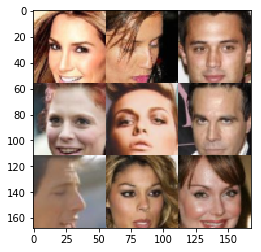

In [2]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
from PIL import Image
import numpy as np
import math

# Image configuration
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
data_dir=r'C:\Users\liori\datasets'
data_files = glob(os.path.join(data_dir, 'celebA/*.jpg'))
shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, 3

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    """
    image = Image.open(image_path)

    if image.size != (width, height):
        # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode='RGB'):
    """
    Get a single image
    """
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):
    """
    Generate batches
    """
    IMAGE_MAX_VALUE = 255


    current_index = 0
    while current_index + batch_size <= shape[0]:
        data_batch = get_batch(
            data_files[current_index:current_index + batch_size],
            *shape[1:3])

        current_index += batch_size

        yield data_batch / IMAGE_MAX_VALUE - 0.5

def images_square_grid(images, mode='RGB'):
    """
    Helper function to save images as a square grid (visualization)
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im
        
test_images = get_batch(glob(os.path.join(data_dir, 'celebA/*.jpg'))[:10], 56, 56)
pyplot.imshow(images_square_grid(test_images))

In [3]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    """
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    """
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # using 4 layer network as in DCGAN Paper
        
        # Conv 1
        conv1 = tf.layers.conv2d(images, 32, 5, 2, 'SAME')
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        
        # Conv 2
        conv2 = tf.layers.conv2d(lrelu1, 64, 5, 2, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Conv 3
        conv3 = tf.layers.conv2d(lrelu2, 128, 5, 2, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
       
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4*4*128))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits

In [4]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First fully connected layer
        x_1 = tf.layers.dense(z, 2*2*128)
        
        # Reshape it to start the convolutional stack
        deconv_2 = tf.reshape(x_1, (-1, 2, 2, 128))
        batch_norm2 = tf.layers.batch_normalization(deconv_2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        # Deconv 1
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, 2, padding='VALID')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        
        # Deconv 2
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 32, 5, 2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 5, 2, padding='SAME')
        
        out = tf.tanh(logits)
        
        return out

In [5]:

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    """
    
    label_smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
                                                  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake) * label_smoothing))
    
    
    return d_loss, g_loss

In [6]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [7]:
def images_square_grid(images, mode='RGB'):
    """
    Helper function to save images as a square grid (visualization)
    """
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))
    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

def show_generator_output(sess, n_images, input_z, out_channel_dim):
    """
    Show example output for the generator
    """
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    pyplot.imshow(images_square_grid(samples))
    pyplot.show()

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape):
    """
    Train the GAN
    """
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    my_session = tf.Session()
    
    with my_session as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # values range from -0.5 to 0.5, therefore scale to range -1, 1
                batch_images = batch_images * 2
                steps += 1
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 400 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3])
    return my_session

Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 1.9325


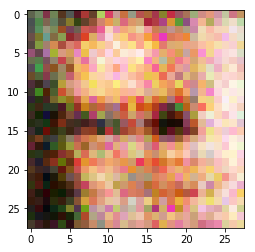

Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 1.5457


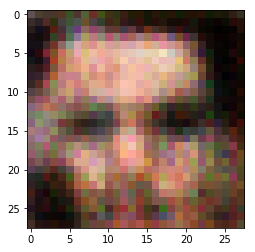

Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 0.8618


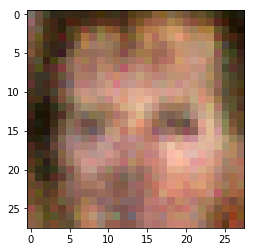

Epoch 1/2... Discriminator Loss: 0.7385... Generator Loss: 1.2557


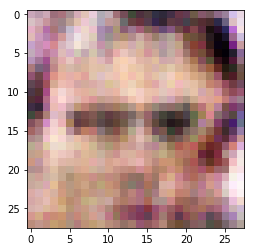

Epoch 1/2... Discriminator Loss: 0.6682... Generator Loss: 1.5009


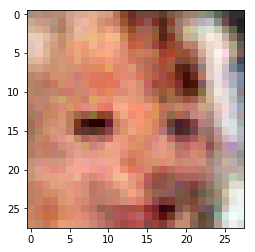

Epoch 1/2... Discriminator Loss: 0.9397... Generator Loss: 1.5030


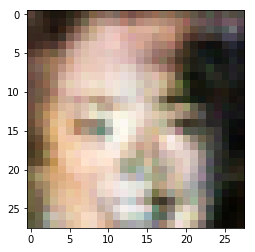

Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.4261


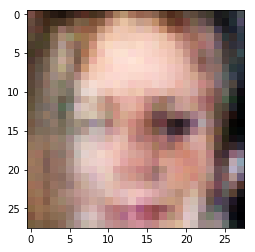

Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.6409


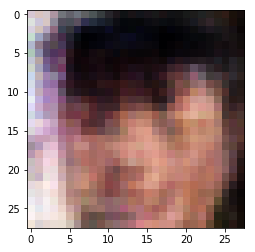

Epoch 1/2... Discriminator Loss: 0.5760... Generator Loss: 1.9395


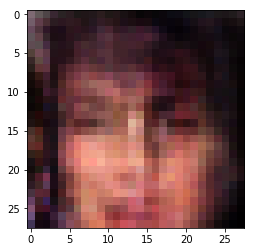

Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 1.7440


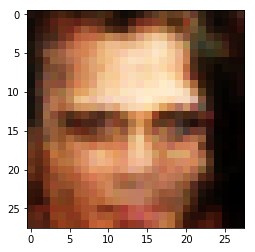

Epoch 1/2... Discriminator Loss: 0.8680... Generator Loss: 0.9559


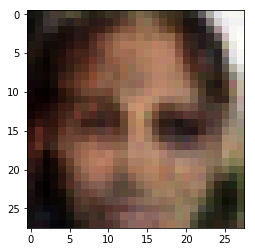

Epoch 1/2... Discriminator Loss: 0.6736... Generator Loss: 1.5816


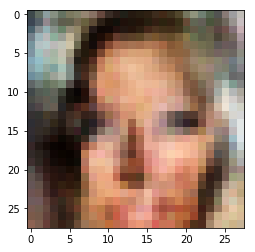

Epoch 1/2... Discriminator Loss: 0.7962... Generator Loss: 1.1654


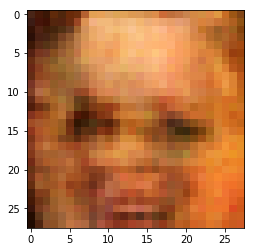

Epoch 1/2... Discriminator Loss: 0.7329... Generator Loss: 1.2558


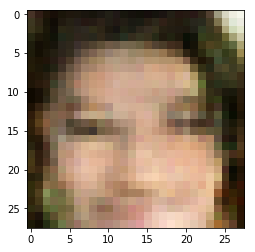

Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 1.2898


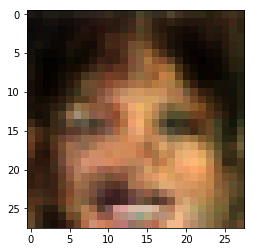

Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.7158


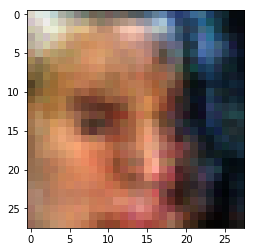

Epoch 1/2... Discriminator Loss: 0.6049... Generator Loss: 1.5911


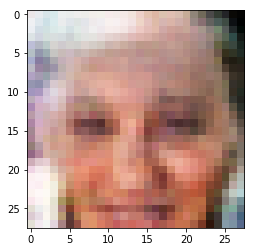

Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 1.2496


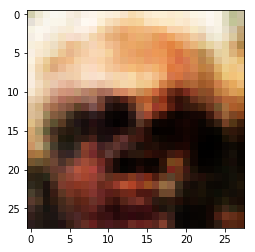

Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.4123


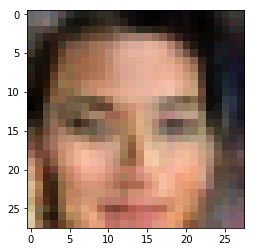

Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.2633


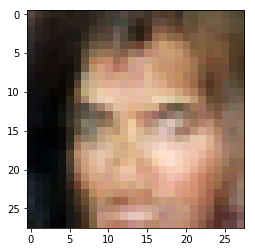

Epoch 1/2... Discriminator Loss: 0.5412... Generator Loss: 1.7403


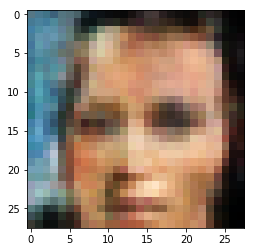

Epoch 1/2... Discriminator Loss: 0.8704... Generator Loss: 1.0646


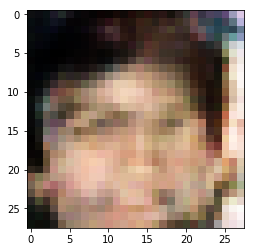

Epoch 1/2... Discriminator Loss: 0.6632... Generator Loss: 1.6886


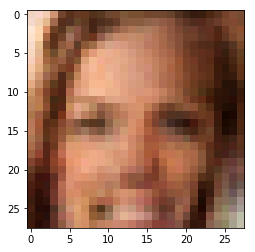

Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.4587


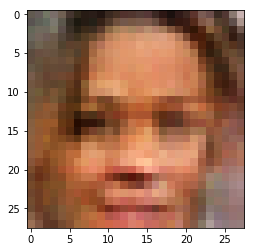

Epoch 1/2... Discriminator Loss: 0.7105... Generator Loss: 1.6518


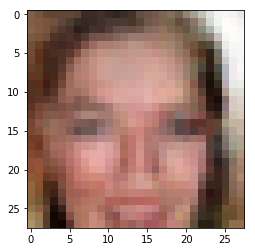

Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.3443


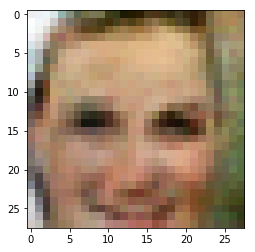

Epoch 1/2... Discriminator Loss: 0.7172... Generator Loss: 1.4350


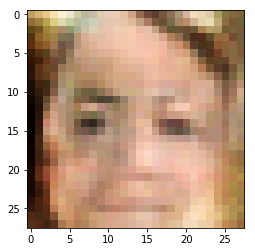

Epoch 1/2... Discriminator Loss: 0.5777... Generator Loss: 1.6800


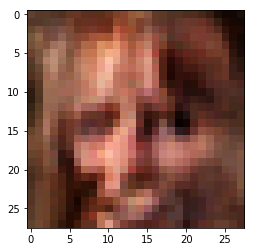

Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 0.9615


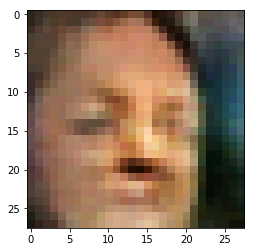

Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.0925


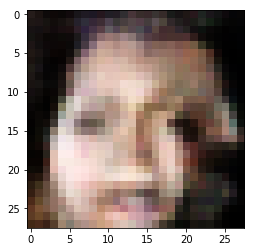

Epoch 1/2... Discriminator Loss: 0.6404... Generator Loss: 1.4312


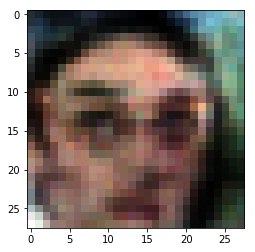

Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 1.3550


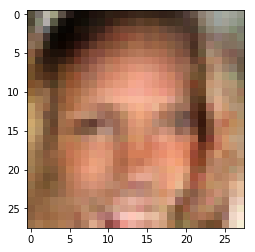

Epoch 2/2... Discriminator Loss: 1.0302... Generator Loss: 0.7944


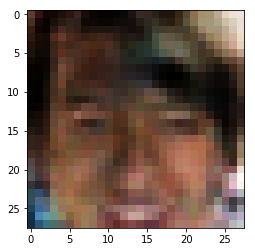

Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 1.3541


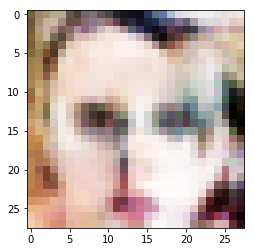

Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.5787


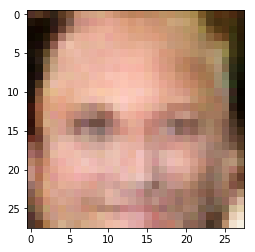

Epoch 2/2... Discriminator Loss: 0.6216... Generator Loss: 1.9412


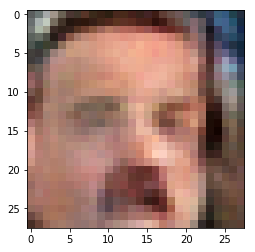

Epoch 2/2... Discriminator Loss: 0.8272... Generator Loss: 1.2921


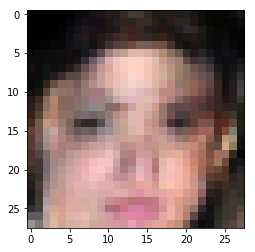

Epoch 2/2... Discriminator Loss: 0.7840... Generator Loss: 1.1295


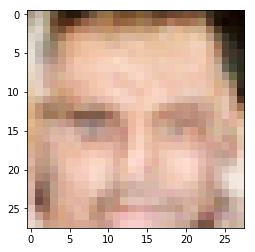

Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.3548


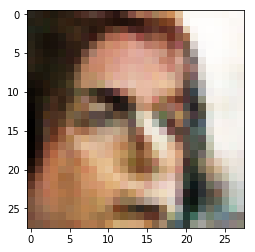

Epoch 2/2... Discriminator Loss: 0.8453... Generator Loss: 1.1012


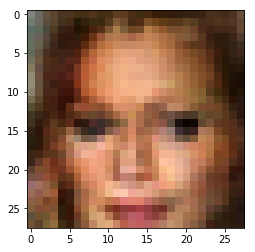

Epoch 2/2... Discriminator Loss: 0.5183... Generator Loss: 2.1160


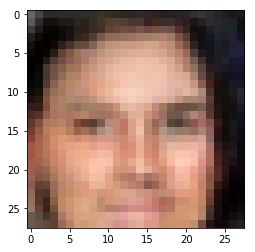

Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 0.7814


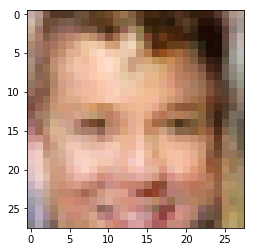

Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.0863


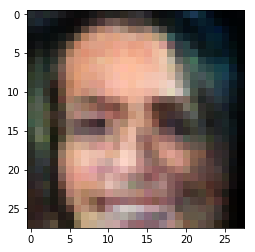

Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.7676


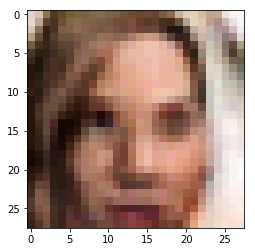

Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.6329


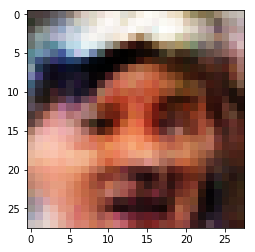

Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 1.2559


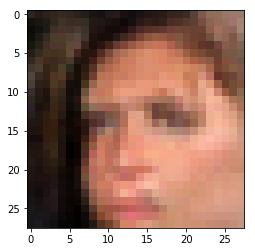

Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.1013


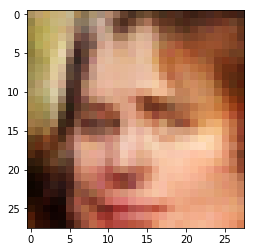

Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.2563


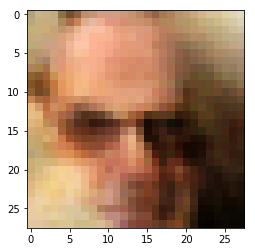

Epoch 2/2... Discriminator Loss: 0.7118... Generator Loss: 1.5989


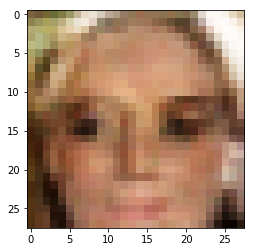

Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 1.5685


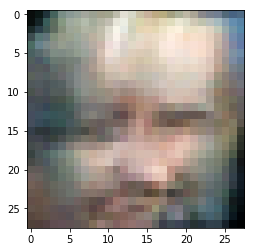

Epoch 2/2... Discriminator Loss: 0.7300... Generator Loss: 1.4112


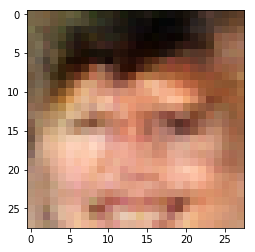

Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 1.6284


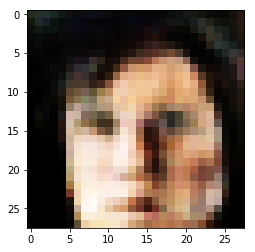

Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 0.9141


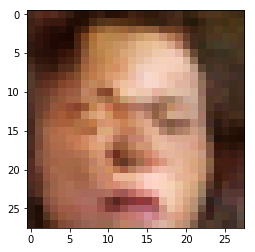

Epoch 2/2... Discriminator Loss: 0.4721... Generator Loss: 2.3129


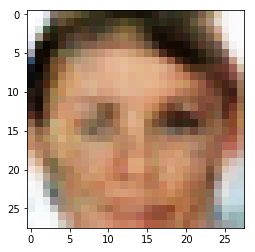

Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.1098


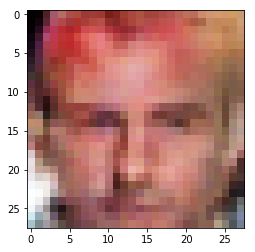

Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 0.9467


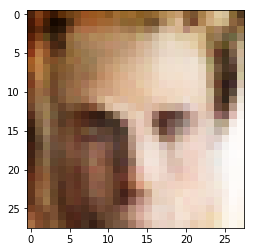

Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 1.1986


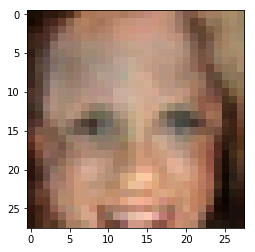

Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 1.6435


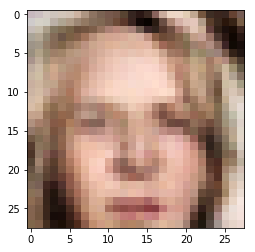

Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 0.9550


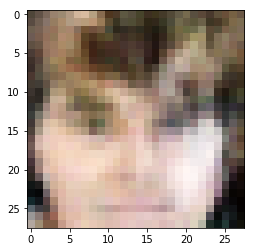

Epoch 2/2... Discriminator Loss: 0.6347... Generator Loss: 1.5071


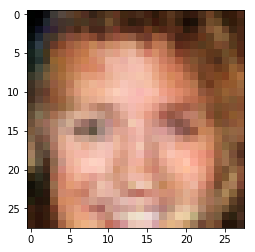

Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.3820


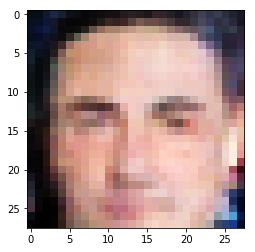

Epoch 2/2... Discriminator Loss: 0.6540... Generator Loss: 1.7970


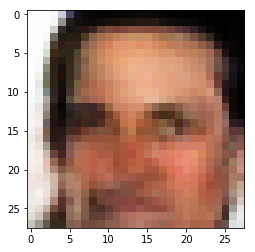

Epoch 2/2... Discriminator Loss: 0.5578... Generator Loss: 1.5877


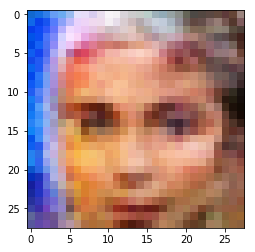

In [11]:

batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
epochs = 2

with tf.Graph().as_default():
    sess = train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, shape)

RuntimeError: Attempted to use a closed Session.